# Online Convex Optimization: Project.
###  Redwan Mekrami, Maxime Haddouche, Henri Alam

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# 1 Preliminary

<font color='red'>1.  Download MNIST dataset in csv at https://pjreddie.com/projects/mnist-in-csv/.</font>

In [2]:
# mnist_train_url = "https://pjreddie.com/media/files/mnist_train.csv"
# mnist_test_url  = https://pjreddie.com/media/files/mnist_test.csv

In [3]:
mnist_train_file = "mnist_train.csv"
mnist_test_file  = "mnist_test.csv"

mnist_train = np.genfromtxt(mnist_train_file, delimiter=',')
mnist_test = np.genfromtxt(mnist_test_file, delimiter=',')

first five rows of our train set:
[[5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [9. 0. 0. ... 0. 0. 0.]]
Shape of our train set (60000, 785)
Shape of our test set (10000, 785)


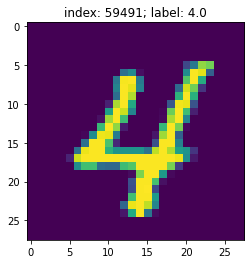

In [4]:
# Check every thing is alright:
print("first five rows of our train set:")
print(mnist_train[:5, :])
print(f'Shape of our train set {mnist_train.shape}') # 59 999 images; 1 + 28*28 = 785
print(f'Shape of our test set {mnist_test.shape}') # 59 999 images; 1 + 28*28 = 785

index = random.randint(0,59999) # 0 to 59 999 included
bi = mnist_train[index, 0]
ai = mnist_train[index, 1:]


plt.imshow(ai.reshape(28,28))
plt.title(f"index: {index}; label: {bi}")
plt.show()

<font color='red'>2.  Consider the binary classification 0 vs other digits.  Create labels $b_i$ and normalize the variable $a_i$ so that the grey scale takes value in [0,1], add an intercept.</font>

From OCO Lecture: Page 8:  
**MNIST: Handwritten digit database $n=60000$ from $a_i$ is a $28 \times 28$ grayscale image, $d=784$ and one can consider two classes, $0$ vs other digits ($b_i= 0$ if the digit is $0$, else $−1$).** 
- We put it to $b_i=1$ if digit is $0$, else $-1$

In [5]:
b_train = (mnist_train[:, 0] == 0)*2 - 1
b_test  = (mnist_test[:, 0] == 0)*2 - 1
print(f"first five bi labels: {b_train[:5]}")

a_train = mnist_train[:, 1:] / (255.) # mnist_train's values ranges from 0 to 255
a_test  = mnist_test[:, 1:]  / (255.)
assert np.max(a_train) == 1.
assert np.min(a_train) == 0.
assert np.max(a_test) == 1.
assert np.min(a_test) == 0.
print("a_train and a_test are normalized and takes value in [0,1]")

first five bi labels: [-1  1 -1 -1 -1]
a_train and a_test are normalized and takes value in [0,1]


# 2 Gradient Descent

<font color='red'>1. Implement the unconstrained GD as seen during OCO lectures.</font>

**hinge regresssion**:
$$
f(x) = \frac{1}{n} \sum_1^n \text{hinge}(b x^T a_i) + \frac{\lambda}{2} ||x||^2
$$

In [6]:
def hinge_regression(x, a, b, llambda):
    cost = 1 - b * np.dot(x, a.T)
    cost[cost <= 0] = 0
    return cost.mean() + llambda/2 * (x**2).sum()

**gradient of hinge regression**:

$$
\nabla f(x) = \frac{1}{n} \sum_1^n (-b*a) \mathbb{1}_{(b x^T a_i)<1}   + \lambda x
$$

In [7]:
def grad_hinge_ression(x, a, b, llambda):
    threshold = b * np.dot(x, a.T)
    grad      = - np.multiply(b, a.T).T
    grad[threshold >= 1] = 0
    return grad.mean(0) + llambda * x

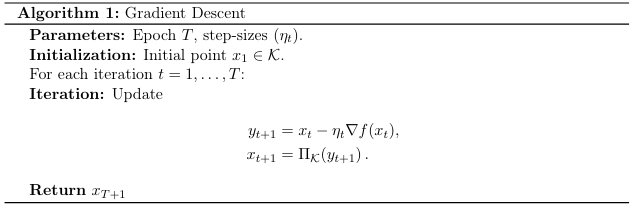

In [8]:
def accuracy(x, b, a):
    res = np.dot(x, a.T)
    res[res >= 0] = 1
    res[res <  0] = -1
    return (res == b).mean()

In [9]:
%%time

def proj(y):
    return y # identity for first test because K = R^d

def gradient_descent_step(eta, grad_f, x_t):
    y_t1 = x_t - eta * grad_f(x_t)
    x_t1 = proj(y_t1)
    return x_t1

def gradient_descent(T, grad_f, f, llambda, eta=None): # f not needed
    x    = np.zeros((T+1, (28*28)))
    if eta is None:
        eta = np.zeros((T)) + 1./10 
    
    for t in range(T):
        eta_t = eta[t] 
        x[t+1]  = gradient_descent_step(eta_t, grad_f, x[t])
    
    return x

llambda = 1./10 
grad_f  = lambda x : grad_hinge_ression(x, a_train, b_train, llambda)
f       = lambda x : hinge_regression(x, a_train, b_train, llambda)
T       = 100
loss_name           = "Hinge Regression Loss"
optimization_method = "Unconstrained Gradient Descend"

x_UGD    = gradient_descent(T, grad_f, f, llambda)
loss_UGD = [f(xx) for xx in x_UGD]
accuracy_over_epoch_UGD = [accuracy(xx, b_test, a_test) for xx in x_UGD]

Wall time: 58 s


[]

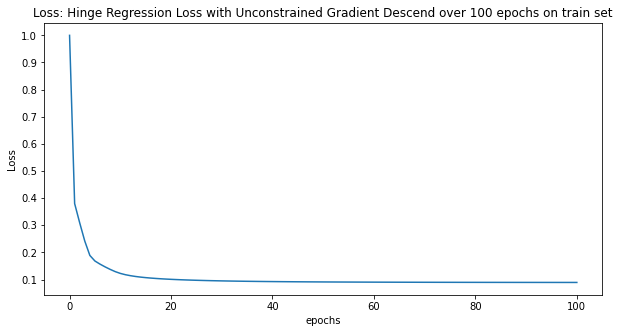

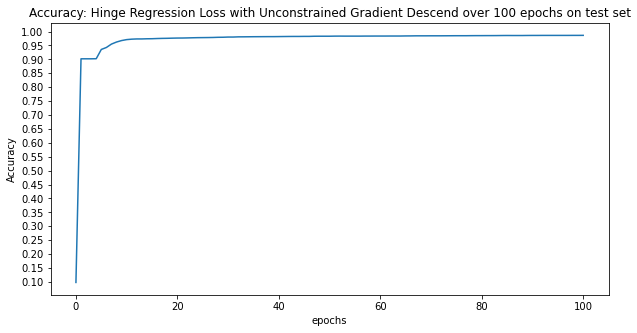

In [10]:
figsize = (10,5)

plt.figure(figsize=figsize)
plt.plot(loss_UGD)
plt.title(f"Loss: {loss_name} with {optimization_method} over {T} epochs on train set")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.locator_params(axis="y", nbins=20)
plt.plot()

plt.figure(figsize=figsize)
plt.plot(accuracy_over_epoch_UGD)
plt.title(f"Accuracy: {loss_name} with {optimization_method} over {T} epochs on test set")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.locator_params(axis="y", nbins=20)
plt.plot()

<font color='red'>2.  Implement also the $l_1$-ball projection and implement the projected GD.</font>

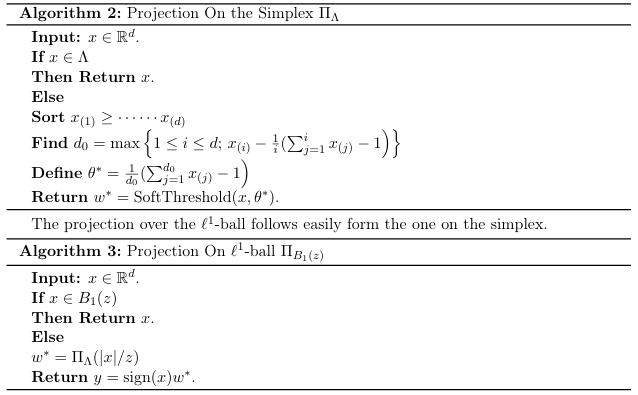

In [11]:
def projection_on_simplex(x, z=1.):
    assert (x >= 0).all() # x must be positive in this implementation
    x_sorted  = np.sort(x)
    sx_sorted = np.cumsum(x_sorted)
    d0        = np.argmax(x_sorted - (sx_sorted-1) / np.arange(1, len(x_sorted)+1))
    theta     = (sx_sorted[d0] - 1) / (d0 +1) # need +1 because math != python indexing matrices
    w         = x - theta # SoftThreshold(x, theta) = sign(x) (abs(x) - theta)_+ ; but x already positive
    w[w <= 0] = 0
    return w

def proj_l1(x, z=1.):
    norm_l1 = np.linalg.norm(x, ord=1)
    if norm_l1 <= z:
        return x
    else:
        w = projection_on_simplex(np.abs(x) / z) # == projection_on_simplex(np.abs(x), z)
        return np.sign(x) * w

In [12]:
%%time

def gradient_descent_step_l1(eta, grad_f, x_t, z=1.):
    y_t1 = x_t - eta * grad_f(x_t)
    x_t1 = proj_l1(y_t1, z)
    return x_t1

def gradient_descent_l1(T, grad_f, f, llambda, eta=None, z=1.): # f not needed
    x    = np.zeros((T+1, (28*28)))
    if eta is None:
        eta = np.zeros((T)) + 1./10 
    
    for t in range(T):
        eta_t = eta[t] 
        x[t+1]  = gradient_descent_step_l1(eta_t, grad_f, x[t], z)
    
    return x

llambda = 1./10 
grad_f  = lambda x : grad_hinge_ression(x, a_train, b_train, llambda)
f       = lambda x : hinge_regression(x, a_train, b_train, llambda)
T       = 100
z       = 100 

loss_name           = "Hinge Regression Loss"
optimization_method = "Projected Gradient Descend"

x_PGD    = gradient_descent_l1(T, grad_f, f, llambda, z=z)
loss_PGD = [f(xx) for xx in x_PGD]
accuracy_over_epoch_PGD = [accuracy(xx, b_train, a_train) for xx in x_PGD]

Wall time: 56.7 s


[]

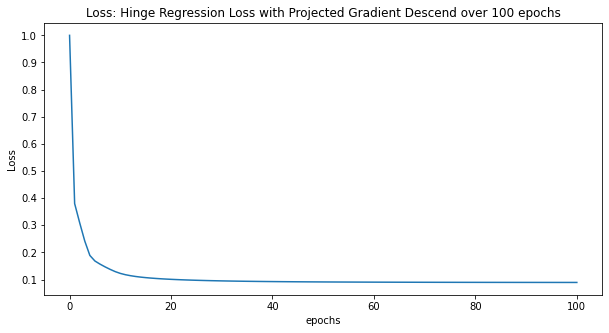

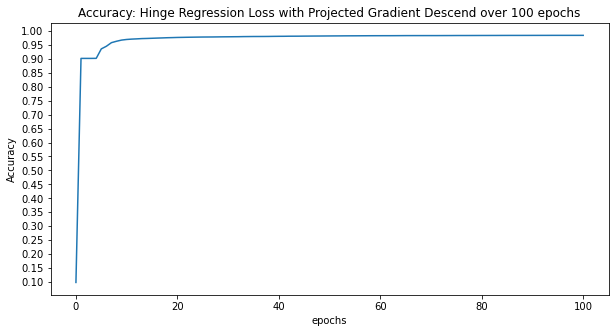

In [13]:
figsize = (10,5)

plt.figure(figsize=figsize)
plt.plot(loss_PGD)
plt.title(f"Loss: {loss_name} with {optimization_method} over {T} epochs")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.locator_params(axis="y", nbins=20)
plt.plot()

plt.figure(figsize=figsize)

plt.plot(accuracy_over_epoch_PGD)
plt.title(f"Accuracy: {loss_name} with {optimization_method} over {T} epochs")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.locator_params(axis="y", nbins=20)
plt.plot()

<font color='red'>3.  Discuss the choice of the hyperparameters $\lambda$ and $z$, the parameter of the $l_2$-regularizationand the radius of the $l_1$-ball, respectively.</font>

Wall time: 24.6 s


[]

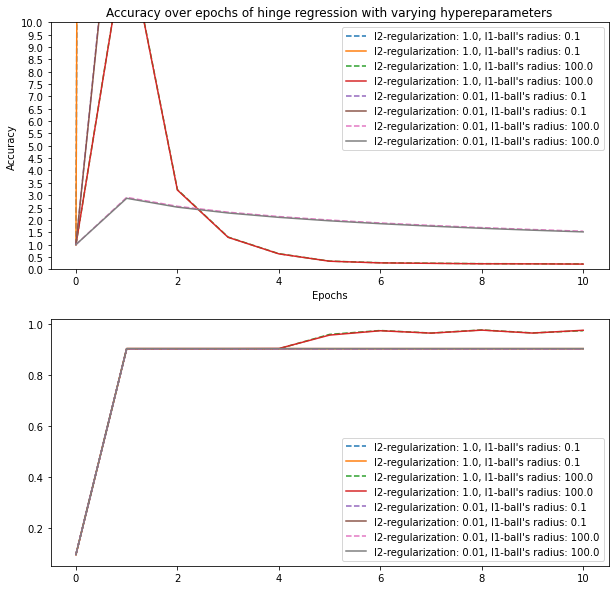

In [14]:
%%time


llambdas = [1., 1./100]  # [1., 1./10, 1./100] 
zs       = [1./10, 100.] # [1./10, 1., 10., 100.]

grad_f  = lambda x : grad_hinge_ression(x, a_train, b_train, llambda)
f       = lambda x : hinge_regression(x, a_train, b_train, llambda)
T       = 10 # less epochs for faster time computation

eta = 1. / np.arange(1, T+1) 

figsize = (10,10)
fig, (ax1, ax2) = plt.subplots(2, figsize=figsize)
for llambda in llambdas:
    grad_f = lambda x : grad_hinge_ression(x, a_train, b_train, llambda)
    f      = lambda x : hinge_regression(x, a_train, b_train, llambda)
    for z in zs:
        x    = gradient_descent_l1(T, grad_f, f, llambda, z=z, eta=eta)
        loss_train = [f(xx) for xx in x]
        loss_test  = [hinge_regression(xx, a_test, b_test, llambda) for xx in x]
        
        accuracy_over_epoch_train = [accuracy(xx, b_train, a_train) for xx in x]
        accuracy_over_epoch_test  = [accuracy(xx, b_test, a_test) for xx in x]
        
        ax1.plot(loss_train, ls="--", label=f"l2-regularization: {llambda}, l1-ball's radius: {z}")
        ax1.plot(loss_test,  ls="-",  label=f"l2-regularization: {llambda}, l1-ball's radius: {z}")
        
        ax2.plot(accuracy_over_epoch_train, ls="--", label=f"l2-regularization: {llambda}, l1-ball's radius: {z}")
        ax2.plot(accuracy_over_epoch_test,  ls="-",  label=f"l2-regularization: {llambda}, l1-ball's radius: {z}")

ax1.set(title ="Loss over epochs of hinge regression with varying hypereparameters",
        xlabel="Epochs",
        ylabel="Loss",
        ylim  = [0.,10.])

ax1.locator_params(axis="y", nbins=20)

ax1.legend(loc="best")

ax1.set(title="Accuracy over epochs of hinge regression with varying hypereparameters",
        xlabel="Epochs",
        ylabel="Accuracy")
ax2.legend(loc="best")

plt.plot()

The better parameters seems to be the red combination, the purple one gives also good results compare to the other ones.

# 3 Stochastic Gradient Descent

<font color='red'>1.  Implement the unconstrained and the projected SGD as seen during OCO lectures.</font>1

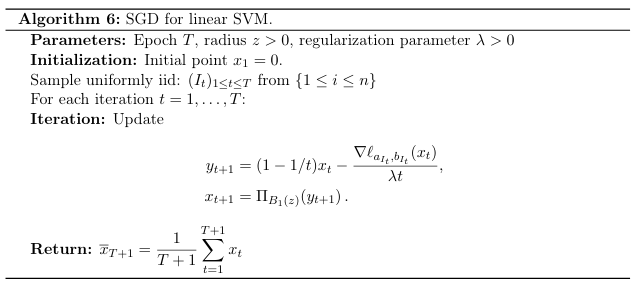

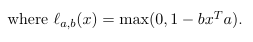

In our case

$$
\ell_{a,b}(x) = hinge\_regression(x, a, b, 0) \\
\nabla \ell_{a,b}(x) = grad\_hinge\_regression(x, a, b, 0)
$$

In [15]:
%%time

def proj(y):
    return y # identity for first test because K = R^d

def SGD_step(eta, t, grad_f, x_t):
    y_t1 = (1. - 1./(t+1)) * x_t - eta * grad_f(x_t)
    x_t1 = proj(y_t1)
    return x_t1

def SGD(x_train, y_train, llambda=1., T=100, eta=None, batches=None, batch_size=1): # f not needed
    # I add a batch size parameter so that the gradient is more stable
    
    x = np.zeros((T+1, (28*28)))
    if eta is None:
        eta = 1. / (np.arange(1,T+1) * llambda) 
    
    if batches is None:
        batches = np.random.choice(len(x_train), (T, batch_size), replace=True)
    
    for t in range(T):
        batch = batches[t]
        grad_f = lambda x : grad_hinge_ression(x, x_train[batch], y_train[batch], 0)
        eta_t = eta[t]
        
        x[t+1]  = SGD_step(eta_t, t, grad_f, x[t])
    
    return x

llambda    = 1.
T          = 1000
batch_size = 10 #we can put it larger to have a more stable gradient 

loss_name           = "Hinge Regression Loss"
optimization_method = "SGD"

x_SGD    = SGD(a_train, b_train, llambda=llambda, T=T, batch_size=batch_size)
loss_SGD = [hinge_regression(xx, a_train, b_train, llambda) for xx in x_SGD]
accuracy_over_epoch_SGD = [accuracy(xx, b_train, a_train) for xx in x_SGD]

Wall time: 37.7 s


[]

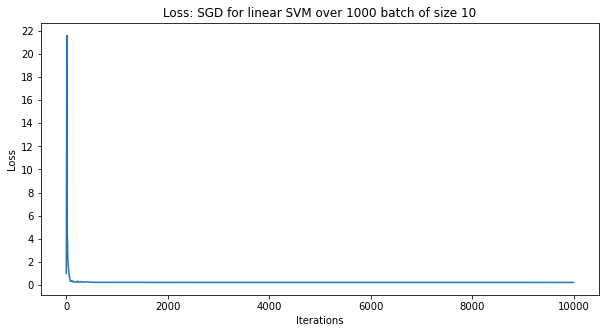

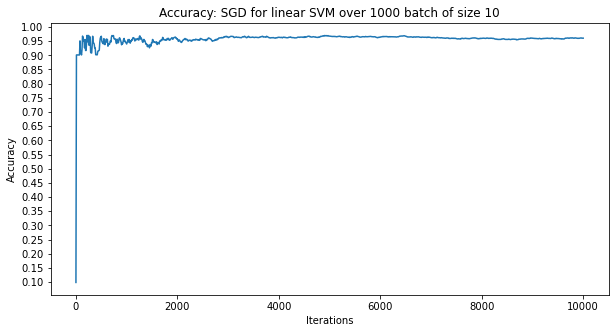

In [16]:
figsize = (10,5)
x_axis_iteration = np.arange(0, T+1) * batch_size

plt.figure(figsize=figsize)
plt.plot(x_axis_iteration, loss_SGD)
plt.title(f"Loss: {optimization_method} for linear SVM over {T} batch of size {batch_size}")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.locator_params(axis="y", nbins=20)
plt.plot()

plt.figure(figsize=figsize)

plt.plot(x_axis_iteration, accuracy_over_epoch_SGD)
plt.title(f"Accuracy: {optimization_method} for linear SVM over {T} batch of size {batch_size}")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.locator_params(axis="y", nbins=20)
plt.plot()

In [17]:
%%time

def SGD_step_l1(eta, t, grad_f, x_t, z=1.):
    y_t1 = (1. - 1./(t+1)) * x_t - eta * grad_f(x_t)
    x_t1 = proj_l1(y_t1, z)
    return x_t1

def SGD_l1(x_train, y_train, llambda=1., T=100, eta=None, z=1., batches=None, batch_size=1): # f not needed
    x = np.zeros((T+1, (28*28)))
    
    if eta is None:
        eta = 1. / (np.arange(1,T+1) * llambda) 
    
    if batches is None:
        batches = np.random.choice(len(x_train), (T, batch_size), replace=True)
    
    for t in range(T):
        batch = batches[t]
        grad_f = lambda x : grad_hinge_ression(x, x_train[batch], y_train[batch], 0)
        eta_t = eta[t]
        
        x[t+1]  = SGD_step_l1(eta_t, t, grad_f, x[t], z)
    
    return x

llambda    = 1.
T          = 1000
z          = 100.
batch_size = 10 # but you can put it larger to have a more stable gradient

loss_name           = "Hinge Regression Loss"
optimization_method = "Projected SGD"

x_SGD_l1 = SGD_l1(a_train, b_train, llambda=llambda, T=T, z=z, batch_size=batch_size)
loss_SGD_l1 = [hinge_regression(xx, a_test, b_test, llambda) for xx in x_SGD_l1]
accuracy_over_epoch_SGD_l1 = [accuracy(xx, b_test, a_test) for xx in x_SGD_l1]

Wall time: 6.62 s


[]

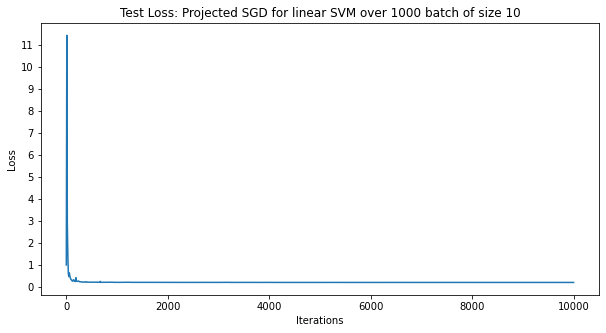

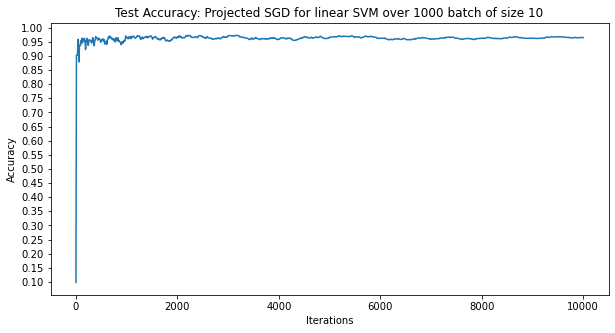

In [18]:
figsize = (10,5)
x_axis_iteration = np.arange(0, T+1) * batch_size

plt.figure(figsize=figsize)
plt.plot(x_axis_iteration, loss_SGD_l1)
plt.title(f"Test Loss: {optimization_method} for linear SVM over {T} batch of size {batch_size}")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.locator_params(axis="y", nbins=20)
plt.plot()

plt.figure(figsize=figsize)

plt.plot(x_axis_iteration, accuracy_over_epoch_SGD_l1)
plt.title(f"Test Accuracy: {optimization_method} for linear SVM over {T} batch of size {batch_size}")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.locator_params(axis="y", nbins=20)
plt.plot()

<font color='red'>2.  Compare  the  accuracy  and  the  running  time  of  the  stochastic  versus  non-stochastic(projected) GD.</font>

- Accurary of both methods are quite similar (near to 1), it might be slightly better for non-stochastic PGD

- However the running time of Projected SGD is much lower (5-60 secondes) whereas the running time of non-stochastic PDG is around (2-3 minutes). This is not surprising because the number of example is around 1000x10=10 000 in the first case and 60000x10=600 000 in the other case. In addition, Python is very slow to do "for loop" hence it is not a very way to compare both algorithm

Hence SGD looks a good approach for this problem. We wonder if SGD has good performance in a dataset where there is a lot of heterogeneity and/or some niche examples. For instance an unbalanced dataset in a classification problem.

# 4 Regularized Follow The Leader

<font color='red'>1.  Implement the Stochastic Mirror Descent and compare with the projected SGD.</font>

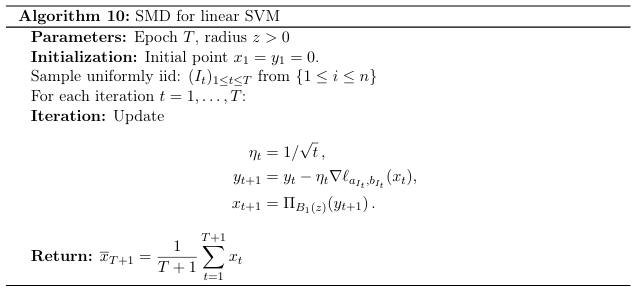

In [19]:
%%time

def SMD_step_l1(eta_t, t, grad_f, x_t, y_t, z=1.):
    y_t1 = y_t - eta_t * grad_f(x_t)
    x_t1 = proj_l1(y_t1, z)
    return x_t1, y_t1

def SMD_l1(x_train, y_train, T=100, eta=None, z=1., batches=None, batch_size=1): # f not needed
    x = np.zeros((T+1, (28*28)))
    y = np.zeros((T+1, (28*28)))
    
    if eta is None:
        eta = 1. / np.sqrt(np.arange(1,T+1))
        
    if batches is None:
        batches = np.random.choice(len(x_train), (T, batch_size), replace=True)
        
    for t in range(T):
        batch = batches[t]
        grad_f = lambda x : grad_hinge_ression(x, x_train[batch], y_train[batch], 0)
        eta_t = eta[t]
        
        x[t+1], y[t+1]  = SMD_step_l1(eta_t, t, grad_f, x[t], y[t], z)
    
    return x

# llambda    = 1. # not needed anymore
T          = 1000
z          = 100.
batch_size = 10

loss_name           = "Hinge Regression Loss"
optimization_method = "Projected SMD"

x_SMD_l1 = SMD_l1(a_train, b_train, T=T, z=z, batch_size=batch_size)
x_SMD_l1 = np.multiply( np.cumsum(x_SMD_l1, axis=0), (1. / np.arange(1,T+2)).reshape(-1,1))
loss_SMD_l1 = [hinge_regression(xx, a_test, b_test, 0) for xx in x_SMD_l1]
accuracy_over_epoch_SMD_l1 = [accuracy(xx, b_test, a_test) for xx in x_SMD_l1]

Wall time: 6.82 s


[]

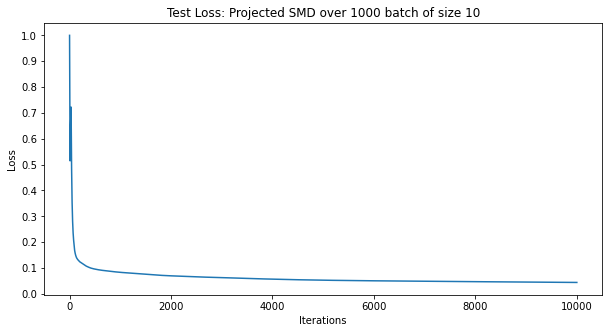

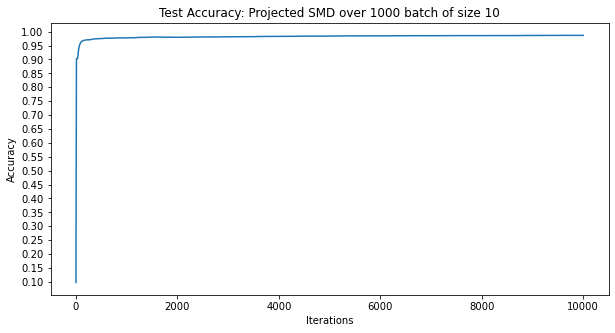

In [20]:
figsize = (10,5)
x_axis_iteration = np.arange(0, T+1) * batch_size

plt.figure(figsize=figsize)
plt.plot(x_axis_iteration, loss_SMD_l1)
plt.title(f"Test Loss: {optimization_method} over {T} batch of size {batch_size}")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.locator_params(axis="y", nbins=20)
plt.plot()

plt.figure(figsize=figsize)

plt.plot(x_axis_iteration, accuracy_over_epoch_SMD_l1)
plt.title(f"Test Accuracy: {optimization_method} over {T} batch of size {batch_size}")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.locator_params(axis="y", nbins=20)
plt.plot()

[]

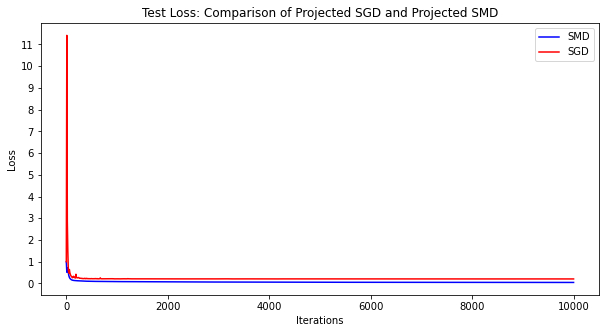

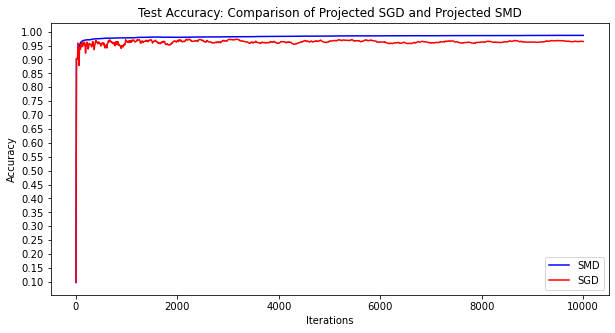

In [21]:
figsize = (10,5)
x_axis_iteration = np.arange(0, T+1) * batch_size

plt.figure(figsize=figsize)
plt.plot(x_axis_iteration, loss_SMD_l1, color="blue", label="SMD")
plt.plot(x_axis_iteration, loss_SGD_l1, color="red",  label="SGD")
plt.title(f"Test Loss: Comparison of Projected SGD and Projected SMD")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.locator_params(axis="y", nbins=20)
plt.legend()
plt.plot()

plt.figure(figsize=figsize)

plt.plot(x_axis_iteration, accuracy_over_epoch_SMD_l1, color="blue", label="SMD")
plt.plot(x_axis_iteration, accuracy_over_epoch_SGD_l1, color="red",  label="SGD")
plt.title(f"Test Accuracy: Comparison of Projected SGD and Projected SMD")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.locator_params(axis="y", nbins=20)
plt.legend()
plt.plot()

- On the one hand, At the earlier steps, SGD is doing better than SMD, while being more noisy due to the stochastic process. In comparison, SMD seems very stable.
- On the other hand, At the later steps, SGD is not increasing its accuracy anymore and SMD slowly and smoothly increases its accuracy.
- We printed the Loss but it's not comparable (and is not the real loss on which we optimize)

<font color='red'>2.  Implement the Stochastic Exponentiated Gradient +/- and compare with the projected SGD.</font>

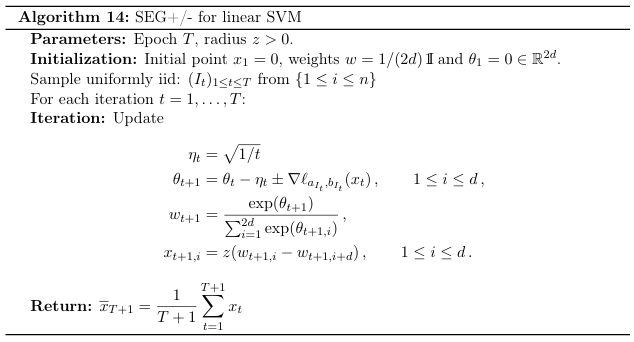

In [22]:
def SEG_pm(x_train, y_train, T=100, eta=None, z=1., batches=None, batch_size=1): # f not needed
    d = 28*28
    x = np.zeros((T+1, d))
    
    #y = np.zeros((T+1, (28*28)))
    W = np.ones(d*2)*(1/(d*2))
    Theta = np.zeros(2*d)
    
    if eta is None:
        eta = 1. / np.sqrt(np.arange(1,T+1))
        
    if batches is None:
        batches = np.random.choice(len(x_train), (T, batch_size), replace=True)
        
    for t in range(T):
        batch = batches[t]
        grad_f = lambda x : grad_hinge_ression(x, x_train[batch], y_train[batch], 0)
        eta_t = eta[t]
        
        Theta[:d] = Theta[:d] - eta_t* grad_f(x[t])
        Theta[d:] = Theta[d:] + eta_t* grad_f(x[t])
        
        W = np.exp(Theta) / np.sum(np.exp(Theta))
        
        x[t+1]= z*(W[:d] - W[d:])
    
    return x


In [23]:
T          = 1000
z          = 100.
batch_size = 10

loss_name           = "Hinge Regression Loss"
optimization_method = "Exp plus minus"

x_exppm_l1 = SEG_pm(a_train, b_train, T=T, z=z, batch_size=batch_size)
x_expm_l1 = np.multiply( np.cumsum(x_exppm_l1, axis=0), (1. / np.arange(1,T+2)).reshape(-1,1))
loss_exppm_l1 = [hinge_regression(xx, a_test, b_test, 0) for xx in x_exppm_l1]
accuracy_over_epoch_exppm_l1 = [accuracy(xx, b_test, a_test) for xx in x_exppm_l1]

[]

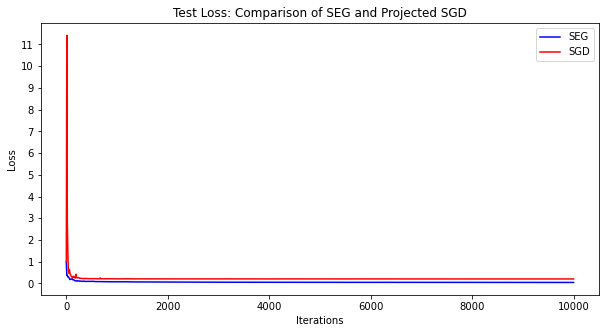

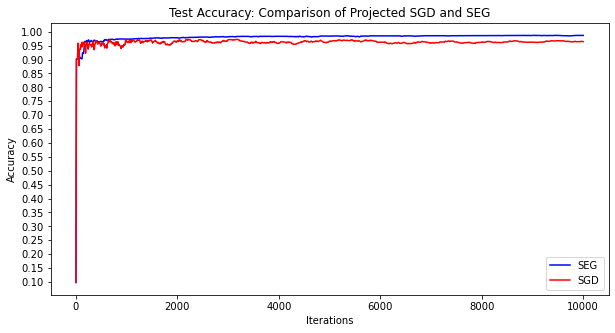

In [24]:
figsize = (10,5)
x_axis_iteration = np.arange(0, T+1) * batch_size

plt.figure(figsize=figsize)
plt.plot(x_axis_iteration, loss_exppm_l1, color="blue", label="SEG")
plt.plot(x_axis_iteration, loss_SGD_l1,color="red",label="SGD")
#plt.plot(x_axis_iteration, loss_ons_l1, color="red",  label="SGD")
plt.title(f"Test Loss: Comparison of SEG and Projected SGD")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.locator_params(axis="y", nbins=20)
plt.legend()
plt.plot()

plt.figure(figsize=figsize)

plt.plot(x_axis_iteration, accuracy_over_epoch_exppm_l1, color="blue", label="SEG")
plt.plot(x_axis_iteration, accuracy_over_epoch_SGD_l1, color="red", label="SGD")
#plt.plot(x_axis_iteration, accuracy_over_epoch_ons_l1, color="red",  label="SGD")
plt.title(f"Test Accuracy: Comparison of Projected SGD and SEG")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.locator_params(axis="y", nbins=20)
plt.legend()
plt.plot()

<font color='red'>3.  Implement the Stochastic AdaGrad and compare with the projected SGD.</font>

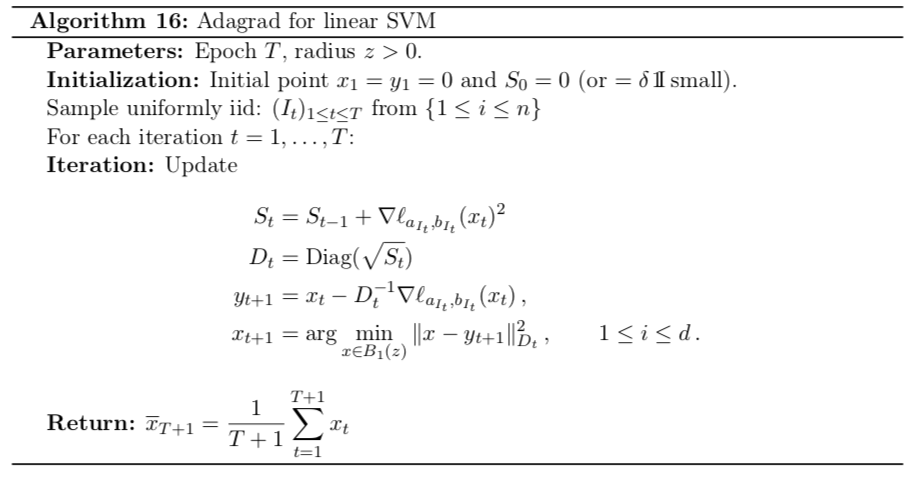

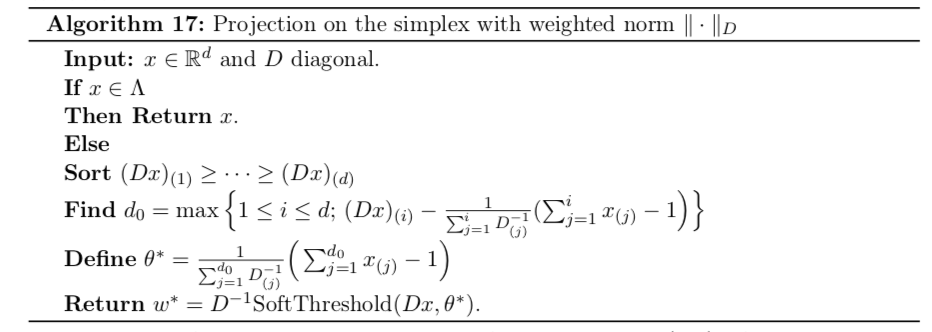

In [25]:
def weighted_projection_on_simplex(x,D,z=1.):
    assert (x >= 0).all() # x must be positive in this implementation
    Dx_sorted  = np.sort(D.dot(x))
    x_sorted = np.sort(x)
    
    inv_D = np.diag(1/D.diagonal()) # for the cumulated sum
    sx_sorted = np.cumsum(x_sorted)
    inv_D_cumsum = np.cumsum(inv_D.diagonal())
    
    d0        = np.argmax(Dx_sorted - (sx_sorted-1)/inv_D_cumsum)
    
    theta     = (sx_sorted[d0] - 1) / inv_D_cumsum[d0] # need +1 because math != python indexing matrices
    w         = D.dot(x) - theta # SoftThreshold(x, theta) = sign(x) (abs(x) - theta)_+ ; but x already positive
    w[w <= 0] = 0
    return inv_D.dot(w)

def weighted_proj_l1(x,D,z=1.):
    norm_l1 = np.linalg.norm(x, ord=1)
    if norm_l1 <= z:
        return x
    else:
        #print(np.abs(x)/z)
        w = weighted_projection_on_simplex(np.abs(x)/z,D) # == projection_on_simplex(np.abs(x), z)
        return np.sign(x) * w

In [26]:
def Adagrad(x_train, y_train, T=100, eta=None, z=1., batches=None, batch_size=1): # f not needed
    d = 28*28
    x = np.zeros((T+1, d))
    y = np.zeros((T+1, d))
    
    delta = 0.1  # if we set delta to zero the algorithm doesnt work perfectly 
    S = np.ones(d)*delta
        
    if batches is None:
        batches = np.random.choice(len(x_train), (T, batch_size), replace=True)
        
    for t in range(T):
        
        batch = batches[t]
        grad_f = lambda x : grad_hinge_ression(x, x_train[batch], y_train[batch], 0)
        
        S = S +  grad_f(x[t])**2
        D = np.diag(np.sqrt(S))
        inv_D = np.diag(1/D.diagonal())
        
        
        y[t+1] = x[t] - inv_D.dot(grad_f(x[t]))

        x[t+1] = weighted_proj_l1(y[t+1],D)
    
    return x



In [27]:
T          = 1000
z          = 100.
batch_size = 10

loss_name           = "Hinge Regression Loss"
optimization_method = "Adagrad"

x_ada_l1 = Adagrad(a_train, b_train, T=T, z=z, batch_size=batch_size)

x_ada_l1 = np.multiply( np.cumsum(x_ada_l1, axis=0), (1. / np.arange(1,T+2)).reshape(-1,1))
loss_ada_l1 = [hinge_regression(xx, a_test, b_test, 0) for xx in x_ada_l1]
accuracy_over_epoch_ada_l1 = [accuracy(xx, b_test, a_test) for xx in x_ada_l1]

[]

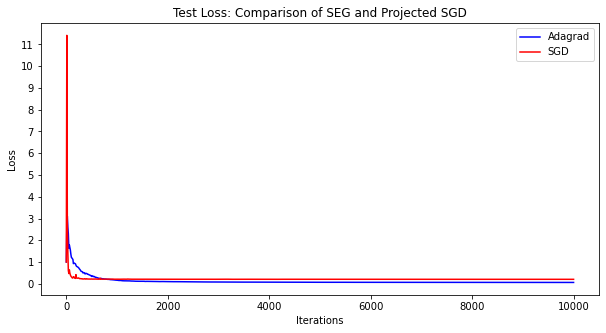

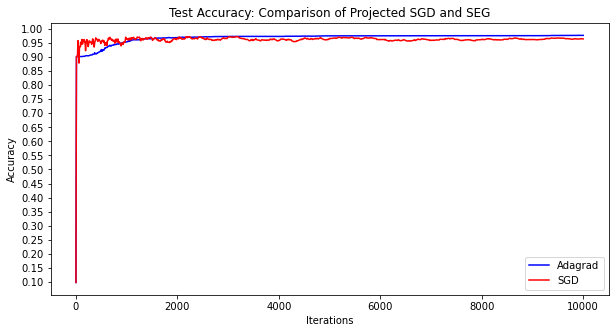

In [28]:
figsize = (10,5)
x_axis_iteration = np.arange(0, T+1) * batch_size

plt.figure(figsize=figsize)
plt.plot(x_axis_iteration, loss_ada_l1, color="blue", label="Adagrad")
plt.plot(x_axis_iteration, loss_SGD_l1,color="red",label="SGD")
#plt.plot(x_axis_iteration, loss_ons_l1, color="red",  label="SGD")
plt.title(f"Test Loss: Comparison of SEG and Projected SGD")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.locator_params(axis="y", nbins=20)
plt.legend()
plt.plot()

plt.figure(figsize=figsize)

plt.plot(x_axis_iteration, accuracy_over_epoch_ada_l1, color="blue", label="Adagrad")
plt.plot(x_axis_iteration, accuracy_over_epoch_SGD_l1, color="red", label="SGD")
#plt.plot(x_axis_iteration, accuracy_over_epoch_ons_l1, color="red",  label="SGD")
plt.title(f"Test Accuracy: Comparison of Projected SGD and SEG")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.locator_params(axis="y", nbins=20)
plt.legend()
plt.plot()

We can see that Adagrad is slower than SGD on the Train Loss but finally reaches a lower value. Furthemore Adagrad accuracy is higher.

# 5 Incomplete information methods

<font color='red'>1.Implement the Stochastic Randomized Exponentiated Gradient +/- and discuss its convergence.</font>

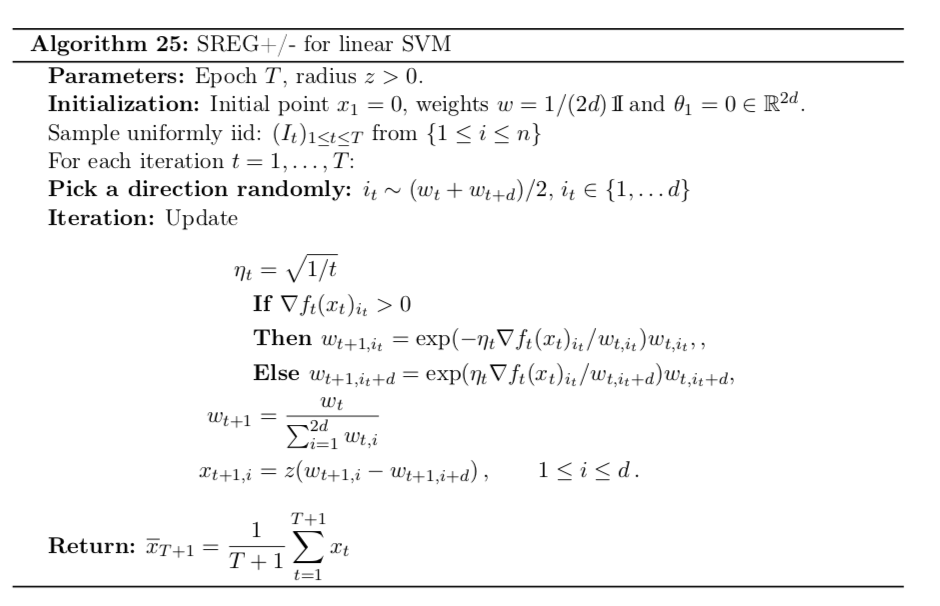

In [29]:
def SREG_pm(x_train, y_train, T=100, eta=None, z=1., batches=None, batch_size=1): # f not needed
    d = 28*28
    x = np.zeros((T+1, d))
    
    #y = np.zeros((T+1, (28*28)))
    W = np.ones(d*2)*(1/(d*2))
    Theta = np.zeros(2*d)
    
    if eta is None:
        eta = 1. / np.sqrt(np.arange(1,T+1))
        
    if batches is None:
        batches = np.random.choice(len(x_train), (T, batch_size), replace=True)
        
    for t in range(T):
        batch = batches[t]
        # sample(1:(2*d),1,prob=w)
        it = np.random.choice(2*d, p=W)
        j = it % d
        pm = 2*int(it < d) - 1
        
        grad_f = lambda x : grad_hinge_ression(x, x_train[batch], y_train[batch], 0)
        eta_t = eta[t]
        if it <= d:
            W[it] = np.exp(-eta_t*grad_f(x[t])[it]/W[it])*W[it]
        else:
            W[it] = np.exp(eta_t*grad_f(x[t])[it-d]/W[it])*W[it]
        
        W = W / sum(W)
        x[t+1]= z*(W[:d] - W[d:])
    
    return x



In [30]:
T          = 1000
z          = 100.
batch_size = 10

loss_name           = "Hinge Regression Loss"
optimization_method = "Randomized Exp plus minus"

x_rexppm_l1 = SREG_pm(a_train, b_train, T=T, z=z, batch_size=batch_size)
x_rexpm_l1 = np.multiply( np.cumsum(x_rexppm_l1, axis=0), (1. / np.arange(1,T+2)).reshape(-1,1))
loss_rexppm_l1 = [hinge_regression(xx, a_test, b_test, 0) for xx in x_rexppm_l1]
accuracy_over_epoch_rexppm_l1 = [accuracy(xx, b_test, a_test) for xx in x_rexppm_l1]

[]

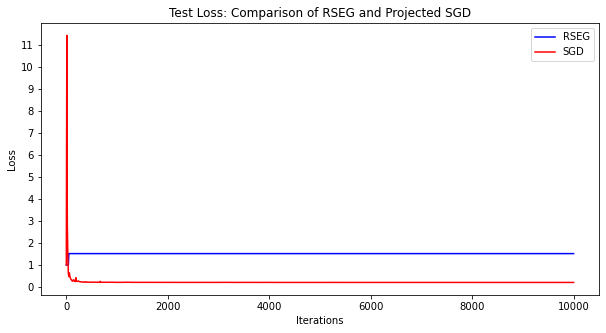

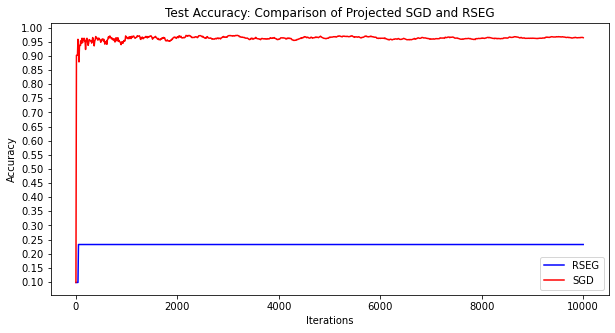

In [31]:
figsize = (10,5)
x_axis_iteration = np.arange(0, T+1) * batch_size

plt.figure(figsize=figsize)
plt.plot(x_axis_iteration, loss_rexppm_l1, color="blue", label="RSEG")
plt.plot(x_axis_iteration, loss_SGD_l1,color="red",label="SGD")
#plt.plot(x_axis_iteration, loss_ons_l1, color="red",  label="SGD")
plt.title(f"Test Loss: Comparison of RSEG and Projected SGD")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.locator_params(axis="y", nbins=20)
plt.legend()
plt.plot()

plt.figure(figsize=figsize)

plt.plot(x_axis_iteration, accuracy_over_epoch_rexppm_l1, color="blue", label="RSEG")
plt.plot(x_axis_iteration, accuracy_over_epoch_SGD_l1, color="red", label="SGD")
#plt.plot(x_axis_iteration, accuracy_over_epoch_ons_l1, color="red",  label="SGD")
plt.title(f"Test Accuracy: Comparison of Projected SGD and RSEG")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.locator_params(axis="y", nbins=20)
plt.legend()
plt.plot()

Because of the randomization, the algorithm produces different result every time and produces mixed performances, but overall they are far from impressing.

# 6 Online Newton Step 

<font color='red'>1.  Implement the Stochastic Online Newton Step.</font>

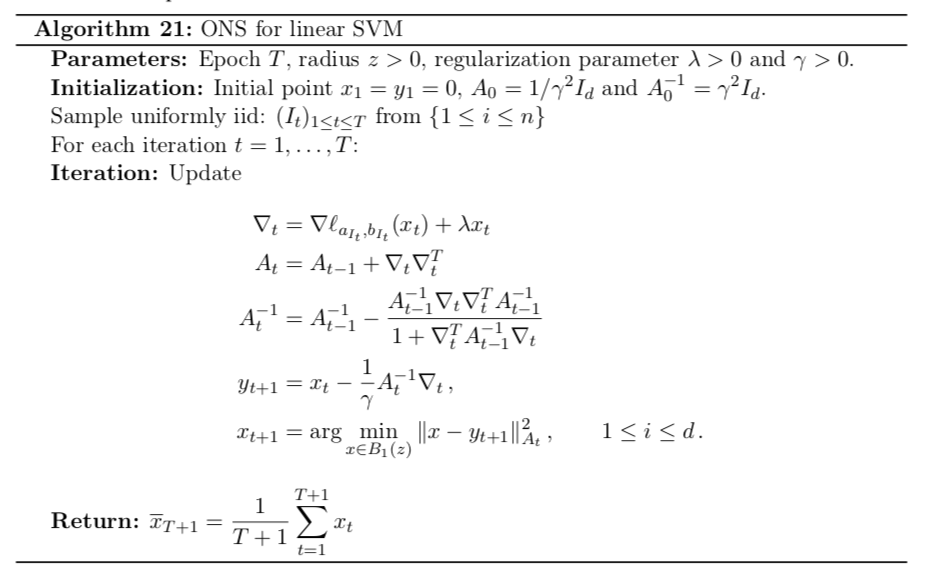

In [32]:
def ONSproj(x_train, y_train, T=100, eta=1/3, z=1., batches=None, batch_size=1):
    x = np.zeros((T+1, (28*28)))
    y = np.zeros((T+1, (28*28)))
    
    if batches is None:
        batches = np.random.choice(len(x_train), (T, batch_size), replace=True)
    
    gamm = (1/2) * min(1/(8*z),1)  # choice is tricky but we could try different numbers
    A = np.eye(28*28)*(1/((gamm**2))) # initialization  
    Ainv = np.eye(28*28)*((gamm**2)) #  initialization
    for t in range(1,T):
        batch = batches[t]
        grad_f = lambda x : grad_hinge_ression(x, x_train[batch], y_train[batch], eta) # instant gradient computation
        
        A += grad_f(x[t]).dot(np.transpose(grad_f(x[t])))
        Ainv -= (1/(1+ grad_f(x[t]).dot(Ainv).dot(np.transpose(grad_f(x[t]))))) * (np.transpose(Ainv).dot(np.transpose(grad_f(x[t])).dot(grad_f(x[t]).dot(Ainv))))    
        
        y[t+1] = x[t] - (1/gamm * Ainv.dot(grad_f(x[t]))) 
        x[t+1] = np.sqrt(Ainv * t).dot(proj_l1(np.sqrt(A/t).dot(y[t+1]), z)) # projection step
        
    return x


In [33]:
T          = 1000
z          = 100.
batch_size = 10

loss_name           = "Hinge Regression Loss"
optimization_method = "Online Newton step"

x_ons_l1 = ONSproj(a_train, b_train, T=T, z=z, batch_size=batch_size)

In [34]:
x_ons_l1 = np.multiply( np.cumsum(x_ons_l1, axis=0), (1. / np.arange(1,T+2)).reshape(-1,1))
loss_ons_l1 = [hinge_regression(xx, a_test, b_test, 0) for xx in x_ons_l1]
accuracy_over_epoch_ons_l1 = [accuracy(xx, b_test, a_test) for xx in x_ons_l1]

[]

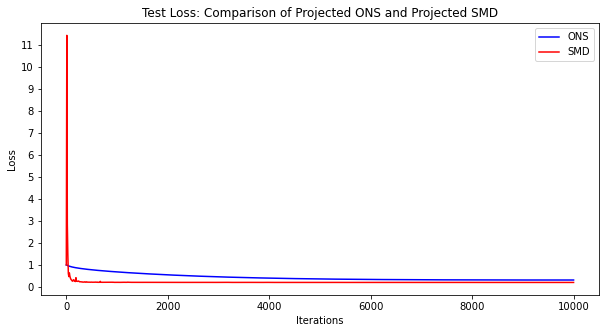

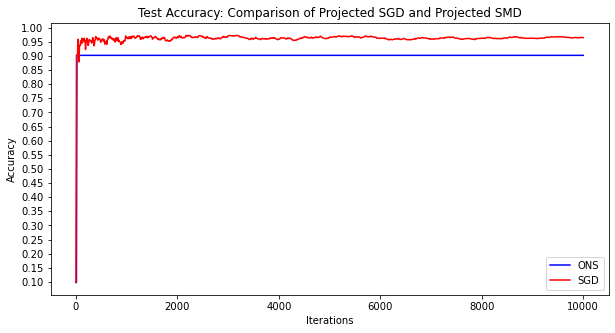

In [35]:
figsize = (10,5)
x_axis_iteration = np.arange(0, T+1) * batch_size

plt.figure(figsize=figsize)
plt.plot(x_axis_iteration, loss_ons_l1, color="blue", label="ONS")
plt.plot(x_axis_iteration, loss_SGD_l1,color="red",label="SMD")
#plt.plot(x_axis_iteration, loss_ons_l1, color="red",  label="SGD")
plt.title(f"Test Loss: Comparison of Projected ONS and Projected SMD")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.locator_params(axis="y", nbins=20)
plt.legend()
plt.plot()

plt.figure(figsize=figsize)

plt.plot(x_axis_iteration, accuracy_over_epoch_ons_l1, color="blue", label="ONS")
plt.plot(x_axis_iteration, accuracy_over_epoch_SGD_l1, color="red", label="SGD")
#plt.plot(x_axis_iteration, accuracy_over_epoch_ons_l1, color="red",  label="SGD")
plt.title(f"Test Accuracy: Comparison of Projected SGD and Projected SMD")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.locator_params(axis="y", nbins=20)
plt.legend()
plt.plot()

We can see that ONS is slower on the Test loss and that his accuracy is lower than SGD. On the other hand, we notice a better stability of the ONS.

# 7. Our take on Bach and Moulines's paper

## New parameters for the SGD

We first re-implement classical SGD with a step-size given by $\eta_n= Cn^{-\alpha}$ for $C,\alpha$ two fixed parameters.

In [36]:
def proj(y):
    return y # identity because in the studied paper, K = R^d

def SGD_step(eta, t, grad_f, x_t):
    y_t1 = (1. - 1./(t+1)) * x_t - eta * grad_f(x_t)
    x_t1 = proj(y_t1)
    return x_t1

def SGD(x_train, y_train, llambda=1., T=100, C=1.0, alpha= 1.0, batches=None, batch_size=1): # f not needed
    # I add a batch size parameter so that the gradient is more stable
    
    x = np.zeros((T+1, (28*28)))
    eta = C/(llambda*(np.arange(1,T+1))**alpha)
    
    if batches is None:
        batches = np.random.choice(len(x_train), (T, batch_size), replace=True)
    
    for t in range(T):
        batch = batches[t]
        grad_f = lambda x : grad_hinge_ression(x, x_train[batch], y_train[batch], 0)
        eta_t = eta[t]
        
        x[t+1]  = SGD_step(eta_t, t, grad_f, x[t])
    
    return x

llambda    = 1.
T          = 1000
batch_size = 10 # We can put it larger to have a more stable gradient 

loss_name           = "Hinge Regression Loss"
optimization_method = "SGD"

[]

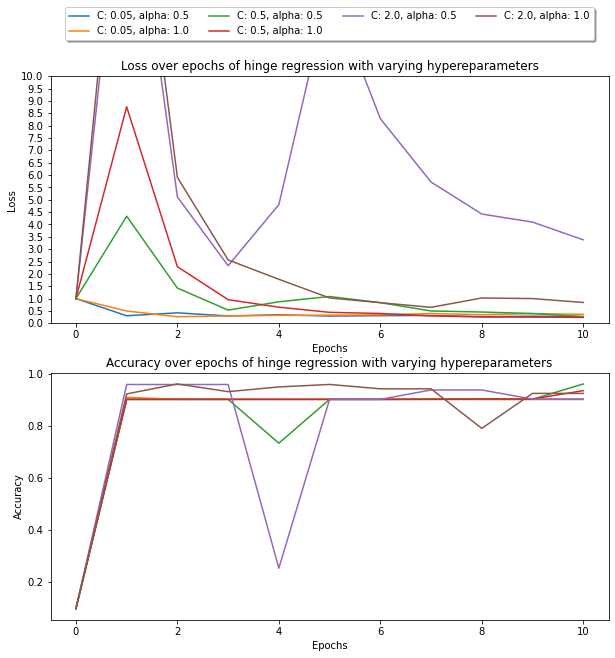

In [37]:
Cs= [1./20,1./2,2.]
alphas = [1./2,1.] 
llambda = 1.


grad_f  = lambda x : grad_hinge_ression(x, a_train, b_train, llambda)
f       = lambda x : hinge_regression(x, a_train, b_train, llambda)
T       = 10 # less epochs for faster time computation




figsize = (10,10)
fig, (ax1, ax2) = plt.subplots(2, figsize=figsize)
for C in Cs:
    for alpha in alphas:
        x    = SGD(a_train, b_train, llambda=llambda, T=T,C=C, alpha= alpha, batch_size=batch_size)
        #loss_train = [f(xx) for xx in x]
        loss_test  = [hinge_regression(xx, a_test, b_test, llambda) for xx in x]
        
        #accuracy_over_epoch_train = [accuracy(xx, b_train, a_train) for xx in x]
        accuracy_over_epoch_test  = [accuracy(xx, b_test, a_test) for xx in x]
        
        #ax1.plot(loss_train, ls="--", label=f"C: {C}, alpha: {alpha}")
        ax1.plot(loss_test,  ls="-",  label=f"C: {C}, alpha: {alpha}")
        
        #ax2.plot(accuracy_over_epoch_train, ls="--", label=f"C: {C}, alpha: {alpha}")
        ax2.plot(accuracy_over_epoch_test,  ls="-",  label=f"C: {llambda}, alpha: {alpha}")

ax1.set(title ="Loss over epochs of hinge regression with varying hypereparameters",
        xlabel="Epochs",
        ylabel="Loss",
        ylim  = [0.,10.])

ax1.locator_params(axis="y", nbins=20)

#ax1.legend(loc="best")

ax2.set(title="Accuracy over epochs of hinge regression with varying hypereparameters",
        xlabel="Epochs",
        ylabel="Accuracy")
#ax2.legend(loc="best")

ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=4, shadow=True)
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=4, shadow=True)

plt.plot()

In [38]:
def SGD_with_PR(x_train, y_train, llambda=1., T=100, C=1.0, alpha= 1.0, batches=None, batch_size=1): # f not needed
    # I add a batch size parameter so that the gradient is more stable
    
    x = np.zeros((T+1, (28*28)))
    y = np.zeros((T+1, (28*28)))
    eta = C/(llambda*(np.arange(1,T+1))**alpha)
    
    if batches is None:
        batches = np.random.choice(len(x_train), (T, batch_size), replace=True)
    
    for t in range(T):
        batch = batches[t]
        grad_f = lambda x : grad_hinge_ression(x, x_train[batch], y_train[batch], 0)
        eta_t = eta[t]
        
        x[t+1]  = SGD_step(eta_t, t, grad_f, x[t])
        y[t+1]= (t*y[t] +x[t+1])/(t+1)
    return y

llambda    = 1.
T          = 1000
batch_size = 10 # We can put it larger to have a more stable gradient 

loss_name           = "Hinge Regression Loss"
optimization_method = "SGD"

[]

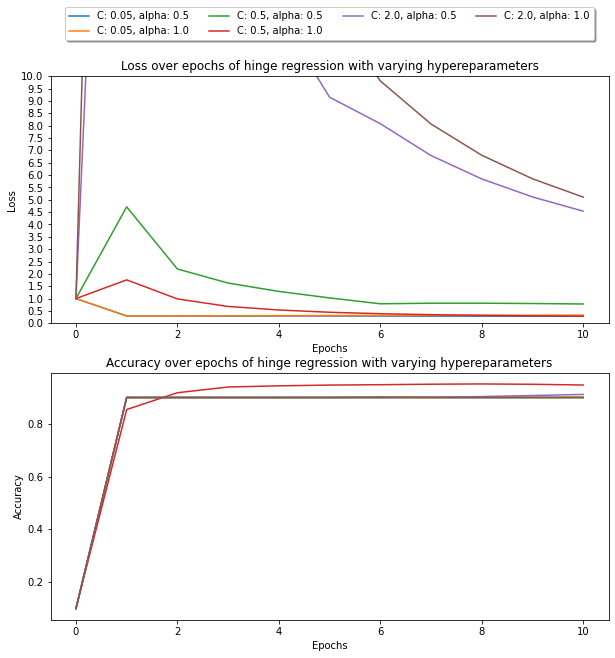

In [39]:
Cs= [1./20,1./2,2.]
alphas = [1./2,1.] 
llambda = 1.


grad_f  = lambda x : grad_hinge_ression(x, a_train, b_train, llambda)
f       = lambda x : hinge_regression(x, a_train, b_train, llambda)
T       = 10 # less epochs for faster time computation




figsize = (10,10)
fig, (ax1, ax2) = plt.subplots(2, figsize=figsize)
for C in Cs:
    for alpha in alphas:
        x    = SGD_with_PR(a_train, b_train, llambda=llambda, T=T,C=C, alpha= alpha, batch_size=batch_size)
        #loss_train = [f(xx) for xx in x]
        loss_test  = [hinge_regression(xx, a_test, b_test, llambda) for xx in x]
        
        #accuracy_over_epoch_train = [accuracy(xx, b_train, a_train) for xx in x]
        accuracy_over_epoch_test  = [accuracy(xx, b_test, a_test) for xx in x]
        
        #ax1.plot(loss_train, ls="--", label=f"C: {C}, alpha: {alpha}")
        ax1.plot(loss_test,  ls="-",  label=f"C: {C}, alpha: {alpha}")
        
        #ax2.plot(accuracy_over_epoch_train, ls="--", label=f"C: {C}, alpha: {alpha}")
        ax2.plot(accuracy_over_epoch_test,  ls="-",  label=f"C: {llambda}, alpha: {alpha}")

ax1.set(title ="Loss over epochs of hinge regression with varying hypereparameters",
        xlabel="Epochs",
        ylabel="Loss",
        ylim  = [0.,10.])

ax1.locator_params(axis="y", nbins=20)

#ax1.legend(loc="best")

ax2.set(title="Accuracy over epochs of hinge regression with varying hypereparameters",
        xlabel="Epochs",
        ylabel="Accuracy")
#ax2.legend(loc="best")

ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=4, shadow=True)
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=4, shadow=True)

plt.plot()